In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
class Maximize(object):
    period = 30
    #np.random.seed(period)

    
    def __init__(self, n, rho, gamma):
        self.n = n
        self.rho = rho
        self.gamma = gamma
        
        
    def MC_data(self):
        self.market_ = stats.norm.rvs(size=(self.n, self.period+1), loc=0, scale=1)
        self.rf_ = stats.norm.rvs(size=(self.n, self.period+1), loc=0, scale=1)
        self.brownian_ = stats.norm.rvs(size=(self.n, self.period+1), loc=0, scale=1)
        self.hc_ = self.rho * self.market_ + np.sqrt(1 - self.rho ** 2) * self.brownian_

        
    def get_original_H(self, hc_mu, hc_sigma):
        dc_rate = np.exp((0.04 + 0.04 + 0.0) * (np.array(range(self.period)) + 1) * (-1))
        
        if self.period == 0:
            self.labor_income = np.zeros([self.n, self.period+1])
            self.H_t = np.zeros([self.n])
        else:
            self.labor_income = self.initial_income*np.cumprod(np.exp(hc_mu+hc_sigma*(self.rho * self.market_[:, :-1] + np.sqrt(1 - self.rho ** 2) * self.hc_[:, :-1])), axis=1)
            self.H_t = self.labor_income @ dc_rate
    
    
    def get_asset_ret(self, market_mu, market_sigma, rf_mu, rf_sigma):
        risky_ret = np.exp(market_mu+(0.5*(market_sigma**2))+market_sigma*self.market_[:, 0])
        rf_ret = np.exp(rf_mu+(0.5*(rf_sigma**2))+rf_sigma*self.rf_[:, 0])
        #rf_ret = np.exp(rf_mu*np.ones(market_[:, 0].shape))
        
        self.R_t =  np.array([risky_ret, rf_ret]).T
    
    
    def fit(self):
        def obj(weight, gamma):
            W_t = (self.initial_wealth+(self.initial_income*0.3))*(self.R_t @ weight)

            if self.gamma == 1:
                obj = np.log(W_t+self.H_t) * (-1)
            else:
                obj = (((W_t+self.H_t) ** (1-self.gamma)) / (1-self.gamma)) * (-1)

            return np.mean(obj)

        x = np.ones([self.R_t.shape[1]]) / self.R_t.shape[1]
        cons = ({'type': 'ineq', 'fun': lambda x: 1 - np.sum(x)},
                {'type': 'ineq', 'fun': lambda x: x},)
        optimized = minimize(obj, x, (self.gamma), method='COBYLA', constraints=cons)
        if not optimized.success: raise BaseException(optimized.message)
        return np.round(optimized.x, 4)
    
        
    def change_parameters(self, period, initial_wealth, initial_income):
        self.period = period
        self.initial_wealth = initial_wealth
        self.initial_income = initial_income

In [3]:
class Maximize_Calibraton(object):
    period = 30
    #np.random.seed(period)
    retirement_age = 60

    
    def __init__(self, n, rho, gamma, aggregate_risk):
        self.n = n
        self.rho = rho
        self.gamma = gamma
        self.aggregate_risk = aggregate_risk
        
            
    def MC_data(self):
        self.market_ = stats.norm.rvs(size=(self.n, self.period+2), loc=0, scale=1)
        self.rf_ = stats.norm.rvs(size=(self.n, self.period+2), loc=0, scale=1)
        self.brownian_ = stats.norm.rvs(size=(self.n, self.period+2), loc=0, scale=1)
        self.hc_ = self.aggregate_risk*(self.rho * self.market_ + np.sqrt(1 - self.rho ** 2) * self.brownian_)


    def get_calibration_H(self, fixed_effect_coeff, age_coeff_list):
        dc_rate = np.exp((0.04 + 0.04 + 0.0) * (np.array(range(self.period+1)) + 1) * (-1))
        age_list = np.array(list(range(self.retirement_age-(self.period+1), self.retirement_age)))

        after_retire_H_t = np.exp(fixed_effect_coeff) / (1-dc_rate[0])
        if self.period == 0:
            self.labor_income = np.exp(fixed_effect_coeff)
            self.H_t = after_retire_H_t
        else:
            ic_list = fixed_effect_coeff + (age_list * age_coeff_list[0]) + ((age_list**2 /10) * age_coeff_list[1]) + ((age_list**3/100) * age_coeff_list[2])
            self.labor_income = np.exp(np.array([ic_list]*self.n)  + self.hc_[:, :-1])
            self.H_t = self.labor_income @ dc_rate + (after_retire_H_t * dc_rate[-1])

    
    def get_asset_ret(self, market_mu, market_sigma, rf_mu, rf_sigma):
        risky_ret = np.exp(market_mu+(0.5*(market_sigma**2))+market_sigma*self.market_[:, 0])
        rf_ret = np.exp(rf_mu+(0.5*(rf_sigma**2))+rf_sigma*self.rf_[:, 0])
        #rf_ret = np.exp(rf_mu*np.ones(market_[:, 0].shape))
        
        self.R_t =  np.array([risky_ret, rf_ret]).T
    
    
    def fit(self):
        def obj(weight, gamma):
            W_t = (self.initial_wealth+(self.initial_income*0.3))*(self.R_t @ weight)

            if self.gamma == 1:
                obj = np.log(W_t+self.H_t) * (-1)
            else:
                obj = (((W_t+self.H_t) ** (1-self.gamma)) / (1-self.gamma)) * (-1)

            return np.mean(obj)

        x = np.ones([self.R_t.shape[1]]) / self.R_t.shape[1]
        cons = ({'type': 'ineq', 'fun': lambda x: 1 - np.sum(x)},
                {'type': 'ineq', 'fun': lambda x: x},)
        optimized = minimize(obj, x, (self.gamma), method='COBYLA', constraints=cons)
        if not optimized.success: raise BaseException(optimized.message)
        return np.round(optimized.x, 4)
    
        
    def change_parameters(self, period, initial_wealth, initial_income, retirement_age=60):
        self.period = period
        self.initial_wealth = initial_wealth
        self.initial_income = initial_income
        self.retirement_age = retirement_age

In [4]:
def lc_asset_allocation(asset_dic, group_characherize_dic, sample_size=20000, gamma=4):
    np.random.seed(30)

    lc_weights = []
    lc_labor_income = []
    lc_wealth = []
    model = Maximize_Calibraton(n=sample_size, rho=group_characherize_data["rho"], gamma=gamma, aggregate_risk=group_characherize_data["aggregate_risk"])
    for i in range(35)[::-1]:

        if i is range(35)[::-1][0]:
            financial_wealth = group_characherize_data["initial_wealth"]
            income = group_characherize_data["initial_income"]
            model.change_parameters(i, financial_wealth, income)
        else:
            financial_wealth = (model.initial_wealth + np.mean(model.labor_income[:, 0]) * 0.3) * np.mean(model.R_t @ model.fit())
            income = np.mean(model.labor_income[:, 0])
            model.change_parameters(i, financial_wealth, income)

        model.MC_data()
        model.get_calibration_H(fixed_effect_coeff=group_characherize_data["fixed_effect_coeff"], age_coeff_list=group_characherize_data["age_coeff_list"])
        model.get_asset_ret(market_mu=asset_data["risky"][0], market_sigma=asset_data["risky"][1], 
                            rf_mu=asset_data["rf"][0], rf_sigma=asset_data["rf"][1])
        opt_weights = model.fit()

        lc_weights.append(opt_weights)
        lc_labor_income.append(np.round(income))
        lc_wealth.append(np.round(financial_wealth))
        #print(model.period, opt_weights * 100, np.round(financial_wealth), np.round(income))

        #print(model.period, model.fit() * 100, np.round(model.initial_wealth), np.round(np.mean(model.labor_income[:, 0])))

    lc_df = pd.DataFrame(lc_weights, columns=["risky_asset", "risk_free"]) * 100
    lc_total_df = pd.DataFrame(np.array([lc_labor_income, lc_wealth]).T, index=range(35)[::-1], columns=["labor_income", "financial_wealth"])
    
    return lc_df, lc_total_df


def data_plotting(lc_total_df):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)

    ln1 = ax.plot(lc_total_df.index[::-1], lc_total_df.labor_income, color="b", label="labor_income")
    ax2 = ax.twinx()
    ln2 = ax2.plot(lc_total_df.index[::-1], lc_total_df.financial_wealth, color="r", linestyle="--", label="financial_wealth")

    lns = ln1+ln2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs)

    plt.show()
    

def lc_weights_plot(lc_df):
    plt.figure(figsize=(10, 5))
    plt.fill_between(lc_df.index, lc_df["risky_asset"])
    plt.fill_between(lc_df.index, lc_df["risky_asset"], 100)
    plt.legend(["risky_asset", "risk_free"])
    plt.ylim(0, 100)
    plt.show()

In [5]:
asset_data = {"risky": [0.12, 0.35], "rf":[0.04, 0.03]}

## High_school & employ group
_______________

In [6]:
group_characherize_data = {"rho":0.522984, "aggregate_risk":np.sqrt(0.118801+0.009552), 
                           "fixed_effect_coeff":[7.492620-0.390035+0.330761+0.058637*2], "age_coeff_list":[-0.013523, 0.012117, -0.001289], 
                           "initial_wealth":1000, 
                           "initial_income":np.exp(7.492620-0.390035+0.330761+0.058637*2 + (25 * -0.013523 + ((25**2 /10) *0.012117) + ((25**3/100) * -0.001289)))}

In [7]:
lc_weights, lc_data = lc_asset_allocation(asset_dic=asset_data, group_characherize_dic=group_characherize_data, sample_size=20000, gamma=4)

In [8]:
lc_data.T

,34,33,32,31,30,29,28,27,26,25,...,9,8,7,6,5,4,3,2,1,0
labor_income,2365.0,2518.0,2575.0,2647.0,2717.0,2765.0,2847.0,2919.0,2992.0,3061.0,...,4214.0,4269.0,4314.0,4326.0,4367.0,4391.0,4426.0,4419.0,4411.0,4422.0
financial_wealth,1000.0,2236.0,3829.0,5900.0,8572.0,11941.0,16302.0,21885.0,29071.0,37413.0,...,533477.0,610797.0,700913.0,801195.0,916817.0,1048342.0,1198988.0,1368790.0,1560231.0,1790072.0


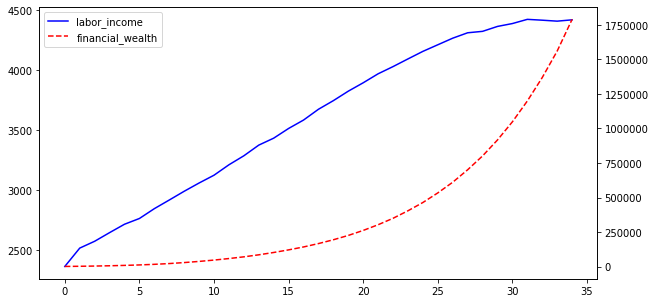

In [9]:
data_plotting(lc_data)

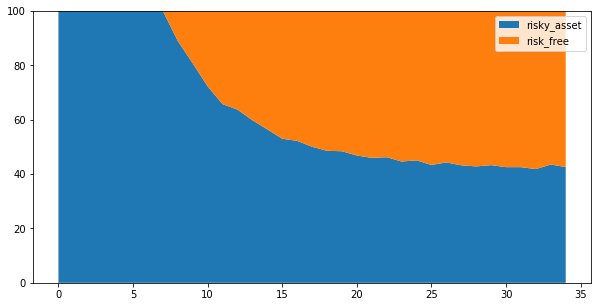

In [10]:
lc_weights_plot(lc_weights)

## High_school & unemploy group
_______________

In [11]:
group_characherize_data = {"rho":0.608529, "aggregate_risk":np.sqrt(0.246465+0.003320), 
                           "fixed_effect_coeff":[7.617263+3.981756+0.281217+0.056456*2], "age_coeff_list":[-0.304786, 0.074977, -0.0055740], 
                           "initial_wealth":1000, 
                           "initial_income":np.exp(7.617263+3.981756+0.281217+0.056456*2 + (25 * -0.304786 + ((25**2 /10) *0.074977) + ((25**3/100) * -0.0055740)))}

In [12]:
lc_weights, lc_data = lc_asset_allocation(asset_dic=asset_data, group_characherize_dic=group_characherize_data, sample_size=20000, gamma=4)

In [13]:
lc_data.T

,34,33,32,31,30,29,28,27,26,25,...,9,8,7,6,5,4,3,2,1,0
labor_income,3600.0,4072.0,3941.0,3867.0,3805.0,3722.0,3717.0,3710.0,3716.0,3732.0,...,5596.0,5760.0,5914.0,6006.0,6169.0,6275.0,6421.0,6459.0,6508.0,6577.0
financial_wealth,1000.0,2829.0,5106.0,7997.0,11666.0,16236.0,22106.0,29582.0,39169.0,51291.0,...,1929681.0,2281759.0,2700545.0,3173490.0,3727991.0,4368034.0,5112314.0,5961157.0,6929989.0,8110720.0


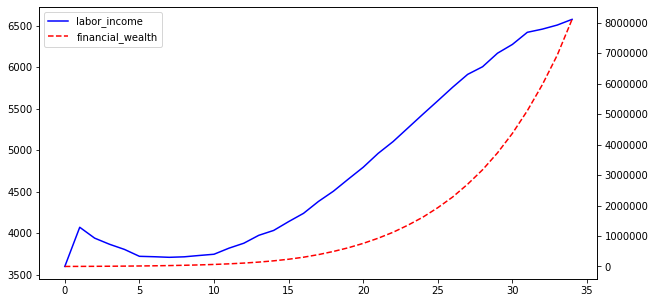

In [14]:
data_plotting(lc_data)

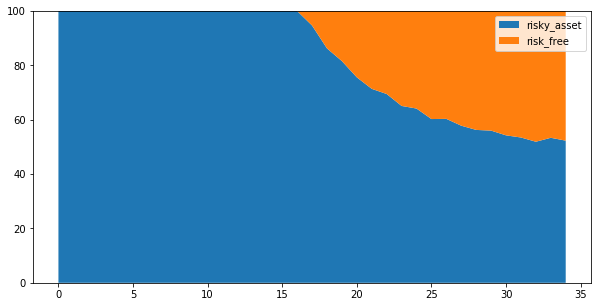

In [15]:
lc_weights_plot(lc_weights)

## College & employ group
_______________

In [16]:
group_characherize_data = {"rho":0.239909, "aggregate_risk":np.sqrt(0.115425+0.009234), 
                           "fixed_effect_coeff":[7.789935-2.649108+0.250728+0.056473*2], "age_coeff_list":[0.151044, -0.026576, 0.001650], 
                           "initial_wealth":1000, 
                           "initial_income":np.exp(7.789935-2.649108+0.250728+0.056473*2 + (25 * 0.151044 + ((25**2 /10) *-0.026576) + ((25**3/100) * 0.001650)))}

In [17]:
lc_weights, lc_data = lc_asset_allocation(asset_dic=asset_data, group_characherize_dic=group_characherize_data, sample_size=20000, gamma=4)

In [18]:
lc_data.T

,34,33,32,31,30,29,28,27,26,25,...,9,8,7,6,5,4,3,2,1,0
labor_income,2637.0,2803.0,2937.0,3085.0,3225.0,3335.0,3479.0,3605.0,3724.0,3837.0,...,5060.0,5118.0,5162.0,5180.0,5226.0,5277.0,5339.0,5372.0,5405.0,5473.0
financial_wealth,1000.0,2344.0,4105.0,6420.0,9431.0,13250.0,18211.0,24579.0,32789.0,42617.0,...,616550.0,705370.0,808723.0,923696.0,1056148.0,1206711.0,1379058.0,1573215.0,1791935.0,2054227.0


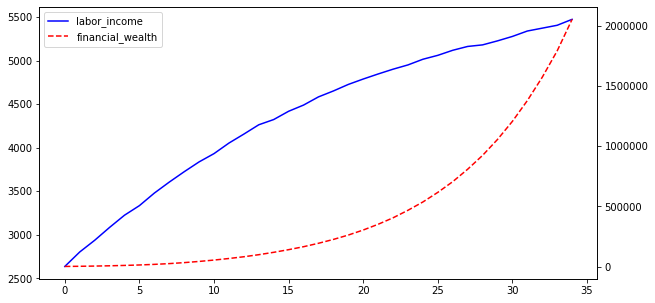

In [19]:
data_plotting(lc_data)

In [20]:
lc_weights

,risky_asset,risk_free
0,100.00,0.00
1,100.00,0.00
2,100.00,0.00
3,100.00,0.00
4,100.00,0.00
5,100.00,0.00
6,100.00,0.00
7,100.00,0.00
8,92.49,7.51
9,82.93,17.07


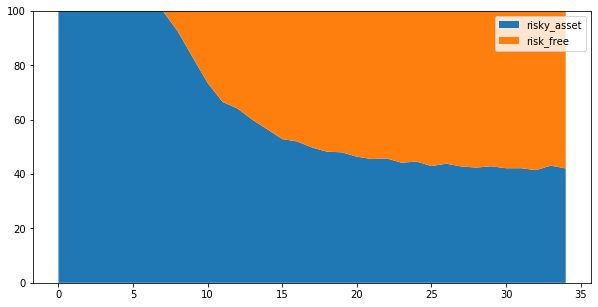

In [21]:
lc_weights_plot(lc_weights)

## College & unemploy group
_______________

In [22]:
group_characherize_data = {"rho":0.422412, "aggregate_risk":np.sqrt(0.216422+0.009279), 
                           "fixed_effect_coeff":[7.775529-9.291528+0.274288+0.043150*2], "age_coeff_list":[0.578539, -0.114316, 0.007483], 
                           "initial_wealth":1000, 
                           "initial_income":np.exp(7.775529-9.291528+0.274288+0.043150*2 + (25 * 0.578539 + ((25**2 /10) *-0.114316) + ((25**3/100) * 0.007483)))}

In [23]:
lc_weights, lc_data = lc_asset_allocation(asset_dic=asset_data, group_characherize_dic=group_characherize_data, sample_size=20000, gamma=4)

In [24]:
lc_data.T

,34,33,32,31,30,29,28,27,26,25,...,9,8,7,6,5,4,3,2,1,0
labor_income,1529.0,1709.0,1966.0,2253.0,2546.0,2816.0,3131.0,3429.0,3718.0,3993.0,...,5790.0,5783.0,5764.0,5699.0,5697.0,5687.0,5718.0,5694.0,5701.0,5764.0
financial_wealth,1000.0,1926.0,3203.0,4950.0,7294.0,10337.0,14367.0,19615.0,26451.0,35200.0,...,578070.0,661590.0,758751.0,866716.0,991023.0,1132302.0,1293916.0,1475860.0,1680745.0,1926492.0


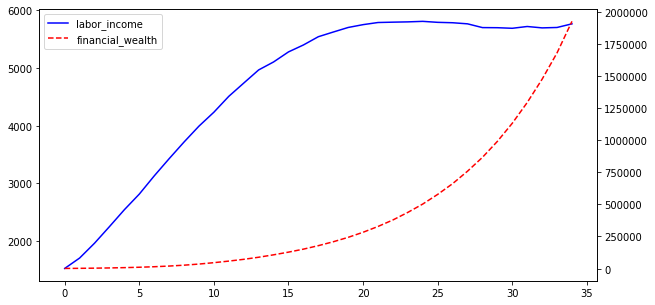

In [25]:
data_plotting(lc_data)

In [26]:
lc_weights

,risky_asset,risk_free
0,100.00,0.00
1,100.00,0.00
2,100.00,0.00
3,100.00,0.00
4,100.00,0.00
5,100.00,0.00
6,100.00,0.00
7,100.00,0.00
8,100.00,0.00
9,94.48,5.52


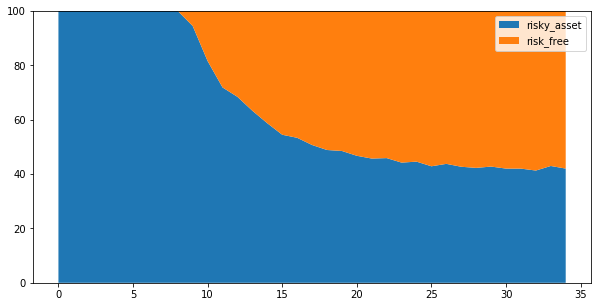

In [27]:
lc_weights_plot(lc_weights)

## University & employ group
_______________

In [28]:
group_characherize_data = {"rho":0.083220, "aggregate_risk":np.sqrt(0.110894+0.005373), 
                           "fixed_effect_coeff":[7.915176-1.868544+0.394303+0.031684*2], "age_coeff_list":[0.066751, -0.000764, -0.000710], 
                           "initial_wealth":1000, 
                           "initial_income":np.exp(7.915176-1.868544+0.394303+0.031684*2 + (25 * 0.066751 + ((25**2 /10) *-0.000764) + ((25**3/100) * -0.000710)))}

In [29]:
lc_weights, lc_data = lc_asset_allocation(asset_dic=asset_data, group_characherize_dic=group_characherize_data, sample_size=20000, gamma=4)

In [30]:
lc_data.T

,34,33,32,31,30,29,28,27,26,25,...,9,8,7,6,5,4,3,2,1,0
labor_income,3024.0,3201.0,3358.0,3536.0,3712.0,3862.0,4052.0,4230.0,4405.0,4578.0,...,6735.0,6799.0,6827.0,6813.0,6809.0,6806.0,6791.0,6730.0,6645.0,6580.0
financial_wealth,1000.0,2496.0,4460.0,7046.0,10416.0,14702.0,20280.0,27454.0,36718.0,48493.0,...,755079.0,864566.0,992004.0,1133715.0,1296898.0,1482403.0,1694730.0,1933846.0,2203244.0,2526274.0


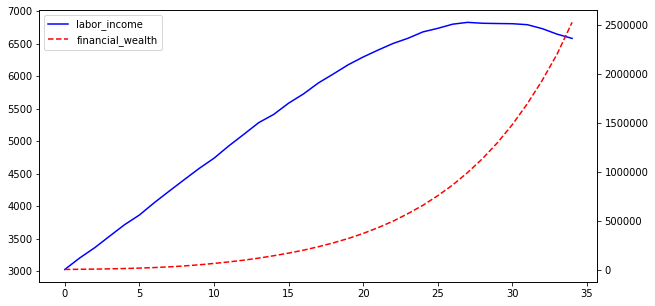

In [31]:
data_plotting(lc_data)

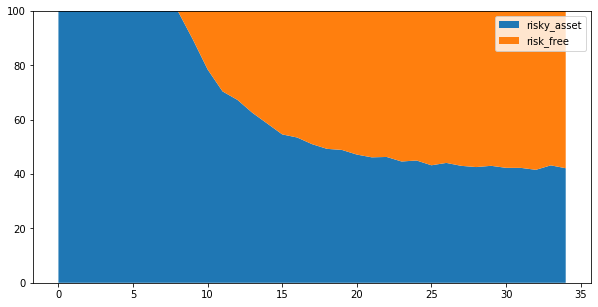

In [32]:
lc_weights_plot(lc_weights)

## University & unemploy group
_______________

In [33]:
group_characherize_data = {"rho":-0.148281, "aggregate_risk":np.sqrt(0.219169+0.006102), 
                           "fixed_effect_coeff":[7.726381-3.200056+0.380076+0.080294*2], "age_coeff_list":[0.182626, -0.031862, 0.001874], 
                           "initial_wealth":1000, 
                           "initial_income":np.exp(7.726381-3.200056+0.380076+0.080294*2 + (25 * 0.182626 + ((25**2 /10) * -0.031862) + ((25**3/100) * 0.001874)))}

In [34]:
lc_weights, lc_data = lc_asset_allocation(asset_dic=asset_data, group_characherize_dic=group_characherize_data, sample_size=20000, gamma=4)

In [35]:
lc_data.T

,34,33,32,31,30,29,28,27,26,25,...,9,8,7,6,5,4,3,2,1,0
labor_income,2791.0,3117.0,3295.0,3493.0,3682.0,3831.0,4025.0,4196.0,4353.0,4507.0,...,5902.0,5958.0,5976.0,5966.0,5968.0,6004.0,6040.0,6039.0,6025.0,6052.0
financial_wealth,1000.0,2465.0,4395.0,6946.0,10277.0,14513.0,20029.0,27122.0,36274.0,47836.0,...,726034.0,830959.0,953047.0,1088863.0,1245291.0,1423147.0,1626654.0,1855946.0,2114242.0,2423981.0


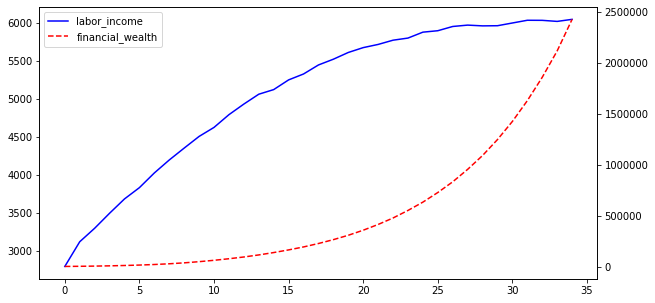

In [36]:
data_plotting(lc_data)

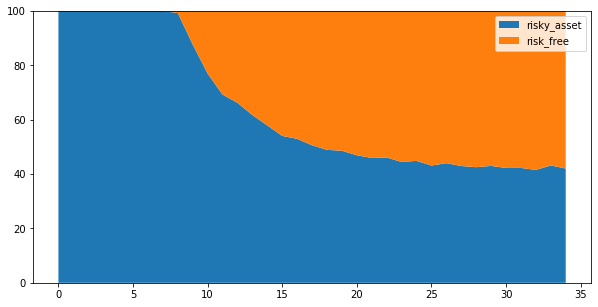

In [37]:
lc_weights_plot(lc_weights)